In [1]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, concatenate, GlobalAveragePooling2D, Input, \
    BatchNormalization, ReLU, Add, Activation, multiply, Reshape, Lambda, Dropout, Concatenate, DepthwiseConv2D
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNet
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow as tf
import tensorflow.keras.backend as K

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        memory_limit = 7680 
        config = tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit)
        for gpu in gpus:
            tf.config.experimental.set_virtual_device_configuration(gpu, [config])
    except RuntimeError as e:
        print(e)

In [3]:
train_datagen = ImageDataGenerator(rescale=1.0 / 255) 
validation_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

DATA_PATH = 'RGB_augmented_300_224'
# DATA_PATH = 'original_8_1_1'
BATCH_SIZE = 16
TARGET_SIZE = (224, 224)

train_generator = train_datagen.flow_from_directory(
    fr'D:\Download\MV_Coursework\Coursework\Code\augmented_image\{DATA_PATH}\train',
    # fr'D:\Download\MV_Coursework\Coursework\Code\dataset_split\{DATA_PATH}\train',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb'
)


validation_generator = validation_datagen.flow_from_directory(
    fr'D:\Download\MV_Coursework\Coursework\Code\augmented_image\{DATA_PATH}\validation',
    # fr'D:\Download\MV_Coursework\Coursework\Code\dataset_split\{DATA_PATH}\validation',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb'
)


test_generator = test_datagen.flow_from_directory(
    fr'D:\Download\MV_Coursework\Coursework\Code\augmented_image\{DATA_PATH}\test',
    # fr'D:\Download\MV_Coursework\Coursework\Code\dataset_split\{DATA_PATH}\test',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb'
)

Found 900 images belonging to 3 classes.
Found 61 images belonging to 3 classes.
Found 63 images belonging to 3 classes.


In [4]:
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
]

In [5]:
weights = [2.25, 2.25, 1]  

def focal_loss_function(weights, gamma=2, eps=1e-7):
    weights = tf.constant(weights, dtype=tf.float32)

    def focal_loss(y_true, y_pred):
        y_pred = tf.reshape(y_pred, (tf.shape(y_pred)[0], tf.shape(y_pred)[1], -1))  
        target = tf.reshape(y_true, tf.shape(y_pred))  

        ce = -1 * tf.math.log(y_pred + eps) * target
        floss = tf.pow((1 - y_pred), gamma) * ce
        floss = floss * weights
        floss = tf.reduce_sum(floss, axis=1)
        return tf.reduce_mean(floss)

    return focal_loss


custom_focal_loss = focal_loss_function(weights)


def weighted_accuracy(weights):
    max_weight = max(weights)
    normalized_weights = [w / max_weight for w in weights]

    def accuracy(y_true, y_pred):
        true_class = K.argmax(y_true, axis=-1)
        pred_class = K.argmax(y_pred, axis=-1)
        accuracy = K.cast(K.equal(true_class, pred_class), 'float32')

        class_weights = K.gather(K.constant(normalized_weights), true_class)
        weighted_accuracy = K.sum(accuracy * class_weights) / K.sum(class_weights)

        return weighted_accuracy

    return accuracy


custom_acc = weighted_accuracy(weights)

In [6]:
def SEBlock(input_tensor, reduction_ratio=16):
    # Squeeze
    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape((1, 1, -1))(se)
    # Excitation
    se = Dense(input_tensor.shape[-1] // reduction_ratio, activation='relu')(se)
    se = Dense(input_tensor.shape[-1], activation='sigmoid')(se)
    return multiply([input_tensor, se])

In [7]:
def adjust_tensor_size(input_tensor, x):
    # Match the number of channels
    if input_tensor.shape[-1] != x.shape[-1]:
        input_tensor = Conv2D(x.shape[-1], 1, padding='same')(input_tensor)
    # Match the height and width
    if input_tensor.shape[1:3] != x.shape[1:3]:
        input_tensor = Conv2D(x.shape[-1], 3, strides=2, padding='same')(input_tensor)
    return input_tensor


def add_residual_connection(input_tensor, x):
    input_tensor = adjust_tensor_size(input_tensor, x)
    return Add()([x, input_tensor])


def MoblieNet_with_Res():
    input_tensor = Input(shape=(224, 224, 3))

    # Initial Conv Layer
    x = Conv2D(32, kernel_size=3, strides=2, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x_first = x

    # First Block
    x = DepthwiseConv2D(3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, 1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = add_residual_connection(x_first, x)
    x = SEBlock(x)

    x_second = x

    # Second Block
    x = DepthwiseConv2D(3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, 1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = add_residual_connection(x_second, x)
    x = SEBlock(x)

    x_third = x

    # Third Block
    x = DepthwiseConv2D(3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, 1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = add_residual_connection(x_third, x)
    x = SEBlock(x)

    # Additional blocks can be added here in a similar fashion

    # Final Layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(rate=0.5)(x)
    output_tensor = Dense(3, activation='softmax')(x)  # Adjust the number of classes as needed

    return Model(inputs=input_tensor, outputs=output_tensor)

In [8]:
def InceptionModule(input_tensor, c1, c2, c3, c4, use_se=False):
    # Path 1
    path1_conv1x1 = Conv2D(c1, 1, activation='relu')(input_tensor)
    
    # Path 2
    path2_conv1x1 = Conv2D(c2[0], 1, activation='relu')(input_tensor)
    path2_conv3x3 = Conv2D(c2[1], 3, padding='same', activation='relu')(path2_conv1x1)
    
    # Path 3
    path3_conv1x1 = Conv2D(c3[0], 1, activation='relu')(input_tensor)
    path3_conv5x5 = Conv2D(c3[1], 5, padding='same', activation='relu')(path3_conv1x1)
    
    # Path 4
    path4_maxpool = MaxPooling2D(3, 1, padding='same')(input_tensor)
    path4_conv1x1 = Conv2D(c4, 1, activation='relu')(path4_maxpool)
    
    x = Concatenate()([path1_conv1x1, path2_conv3x3, path3_conv5x5, path4_conv1x1])

    # SE Block
    if use_se:
        x = SEBlock(x)

    return x

# InceptionModule
def InceptionModuleWithResidual(input_tensor, c1, c2, c3, c4, use_se=False):
    x = InceptionModule(input_tensor, c1, c2, c3, c4, use_se)

    # Match the number of channels
    if input_tensor.shape[-1] != x.shape[-1]:
        input_tensor = Conv2D(x.shape[-1], 1, padding='same', activation='relu')(input_tensor)

    x = Add()([input_tensor, x])
    return x


def Inception_with_residual():
    input_tensor = Input(shape=(224, 224, 3))

    x = Conv2D(64, 7, strides=2, padding='same', activation='relu')(input_tensor)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = Conv2D(64, 1, activation='relu')(x)
    x = Conv2D(192, 3, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = InceptionModuleWithResidual(x, 64, (48, 64), (8, 16), 16, use_se=True)
    x = InceptionModuleWithResidual(x, 96, (64, 96), (16, 32), 32, use_se=True)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    
    x = InceptionModuleWithResidual(x, 128, (64, 96), (16, 32), 32, use_se=True)
    x = InceptionModuleWithResidual(x, 160, (80, 112), (16, 48), 48, use_se=True)
    
    x = InceptionModuleWithResidual(x, 192, (96, 128), (32, 64), 64, use_se=True)
    x = InceptionModuleWithResidual(x, 224, (112, 144), (32, 64), 64, use_se=True)
    
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = InceptionModuleWithResidual(x, 256, (128, 160), (48, 96), 96, use_se=True)
    x = InceptionModuleWithResidual(x, 288, (144, 192), (48, 96), 96, use_se=True)

    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(rate=0.5)(x)
    output_tensor = Dense(3, activation='softmax')(x)

    return Model(inputs=input_tensor, outputs=output_tensor)

In [9]:
model_1 = MoblieNet_with_Res()
model_2 = Inception_with_residual()
concatenated_output = concatenate([model_1.output, model_2.output])

# new_shape = (1, 1, concatenated_output.shape[1])
# x = Reshape(new_shape)(concatenated_output)
# x = Conv2D(filters=128, kernel_size=(1, 1), activation='relu', name='new_conv2d')(x)

x = Dense(units=512, activation='relu')(concatenated_output)
x = Dropout(rate=0.2)(x)
x = Dense(128, activation='relu')(x)
ensemble_model = Dense(3, activation='softmax')(x)
combined_model = Model(inputs=[model_1.input, model_2.input], outputs=ensemble_model)

In [10]:
def generate_ensemble_data(generator):
    while True:
        x, y = generator.next()
        yield [x, x], y  

train_ensemble_generator = generate_ensemble_data(train_generator)
val_ensemble_generator = generate_ensemble_data(validation_generator)
test_ensemble_generator = generate_ensemble_data(test_generator)

import math
train_steps = math.ceil(train_generator.samples / train_generator.batch_size)
val_steps = math.ceil(validation_generator.samples / validation_generator.batch_size)
test_steps = math.ceil(test_generator.samples / test_generator.batch_size)

In [14]:
# combined_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

combined_model.compile(optimizer=Adam(learning_rate=0.0001), loss=custom_focal_loss,metrics=custom_acc)

# combined_model.compile(optimizer=Adam(learning_rate=0.0001), loss=custom_focal_loss,metrics=custom_acc)

# combined_model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
combined_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 112, 112, 64  9472        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 56, 56, 64)   0           ['conv2d_7[0][0]']               
                                                                                            

In [15]:
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     verbose=1,
#     patience=15,
#     mode='min',
#     restore_best_weights=True
# )
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    r"D:\Download\MV_Coursework\Coursework\Code\figure\new_ensemble\ensemble.h5",
    monitor='val_accuracy',       
    verbose=1,                    
    save_best_only=True,          
    mode='max'                   
)

csv_logger = tf.keras.callbacks.CSVLogger(r"D:\Download\MV_Coursework\Coursework\Code\figure\new_ensemble\ensemble.csv", separator=",", append=False)
history = combined_model.fit(
    train_ensemble_generator,
    epochs=150,
    validation_data=val_ensemble_generator,
    validation_steps=val_steps,
    steps_per_epoch=train_steps,
    callbacks=[csv_logger, checkpoint]
)

Epoch 1/150
57/57 [==============================] - ETA: 0s - loss: 0.8735 - accuracy: 0.5082
Epoch 00001: val_accuracy improved from -inf to 0.33840, saving model to D:\Download\MV_Coursework\Coursework\Code\figure\new_ensemble\ensemble.h5


C:\Users\23076\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


57/57 [==============================] - 18s 177ms/step - loss: 0.8735 - accuracy: 0.5082 - val_loss: 0.8969 - val_accuracy: 0.3384
Epoch 2/150
57/57 [==============================] - ETA: 0s - loss: 0.6817 - accuracy: 0.6833
Epoch 00002: val_accuracy improved from 0.33840 to 0.52141, saving model to D:\Download\MV_Coursework\Coursework\Code\figure\new_ensemble\ensemble.h5
57/57 [==============================] - 7s 122ms/step - loss: 0.6817 - accuracy: 0.6833 - val_loss: 0.8782 - val_accuracy: 0.5214
Epoch 3/150
57/57 [==============================] - ETA: 0s - loss: 0.4526 - accuracy: 0.7212
Epoch 00003: val_accuracy did not improve from 0.52141
57/57 [==============================] - 7s 118ms/step - loss: 0.4526 - accuracy: 0.7212 - val_loss: 0.8149 - val_accuracy: 0.3047
Epoch 4/150
57/57 [==============================] - ETA: 0s - loss: 0.3830 - accuracy: 0.6660
Epoch 00004: val_accuracy did not improve from 0.52141
57/57 [==============================] - 7s 118ms/step - loss

In [11]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import pandas as pd

custom_objects = {'focal_loss': custom_focal_loss, 'accuracy': custom_acc}

MODEL_BEST = load_model(r'D:\Download\MV_Coursework\Coursework\Code\figure\new_ensemble\ensemble.h5',custom_objects=custom_objects)

# MODEL_BEST = load_model(r'D:\Download\MV_Coursework\Coursework\Code\figure\new_ensemble\Mixed_augmented_200_224.h5')

# test_loss, test_accuracy = MODEL_BEST.evaluate(test_ensemble_generator, steps=test_steps)
# print('Test Loss:', test_loss)
# print('Test Accuracy:', test_accuracy)

def plot_from_csv(csv_file_path, test_loss, test_accuracy):
    data = pd.read_csv(csv_file_path)
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(data['loss'], label='Train Loss')
    plt.plot(data['val_loss'], label='Validation Loss')
    plt.axhline(y=test_loss, label='Test Loss', color='green', linestyle='--')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    # plt.ylim(0, 1.02)

    plt.subplot(1, 2, 2)
    plt.plot(data['accuracy'], label='Train Accuracy')
    plt.plot(data['val_accuracy'], label='Validation Accuracy')
    plt.axhline(y=test_accuracy, label='Test Accuracy', color='green', linestyle='--')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    # plt.ylim(0, 1.02)
    plt.show()

# plot_from_csv(r'D:\Download\MV_Coursework\Coursework\Code\figure\new_ensemble\ensemble.csv', test_loss, test_accuracy)

In [12]:
# combined_model.save(r'D:\Download\MV_Coursework\Coursework\Code\model\ensemble\4.h5')

In [13]:
# from tensorflow.keras.utils import plot_model
# custom_objects = {'focal_loss': custom_focal_loss, 'accuracy': custom_acc}
# combined_model = load_model(r'D:\Download\MV_Coursework\Coursework\Code\final_model\mobile_with_Res_attention.h5',custom_objects=custom_objects)
# plot_model(combined_model, to_file=r'D:\Download\MV_Coursework\Coursework\Code\figure\new_ensemble\ensemble2.png', show_shapes=True, show_layer_names=True)

In [32]:
from tensorflow.python.keras.losses import CategoricalCrossentropy

# Initialize data and label lists for ensemble testing
ensemble_test_images = []
ensemble_test_labels = []

# Iterate over the test data generator
for i in range(test_steps):
    (x1, x2), y = next(test_ensemble_generator)
    ensemble_test_images.append(x1)  # Assuming x1 and x2 are identical
    ensemble_test_labels.append(y)
# Convert lists to numpy arrays
ensemble_test_data = np.concatenate(ensemble_test_images)
y_true = np.concatenate(ensemble_test_labels)
# Use the combined test data for predictions with the ensemble model
y_probs = MODEL_BEST.predict([ensemble_test_data, ensemble_test_data])

# # 计算 Focal Loss
# focal_loss_value = custom_focal_loss(y_true, y_probs)
# print("Focal Loss:", focal_loss_value.numpy())  # 使用 .numpy() 将 TensorFlow 张量转换为 numpy 数组
# 
# # 计算加权准确率
# weighted_accuracy_value = custom_acc(y_true, y_probs)
# print("Weighted Accuracy:", K.eval(weighted_accuracy_value))  # 使用 K.eval() 评估 Keras 后端张量

loss_function = CategoricalCrossentropy()
accuracy_fuction = tf.keras.metrics.CategoricalAccuracy()
loss = loss_function(y_true, y_probs)
accuracy = accuracy_fuction(y_true, y_probs)

accuracy_percent = accuracy.numpy() * 100
accuracy_percent = "{:.2f}%".format(accuracy_percent)
# loss = "{:.4f}".format(loss.numpy())
print("Accuracy:", accuracy_percent)
print("Loss:", loss.numpy())

Accuracy: 98.41%
Loss: 0.09968976


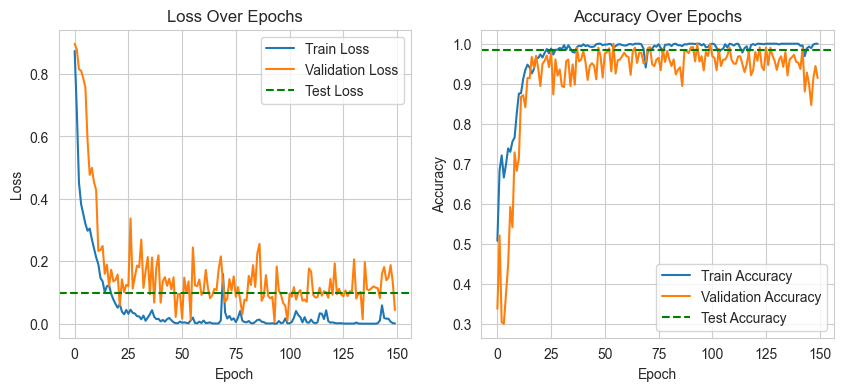

In [33]:
# plot_from_csv(r'D:\Download\MV_Coursework\Coursework\Code\figure\new_ensemble\ensemble.csv', focal_loss_value, weighted_accuracy_value)

plot_from_csv(r'D:\Download\MV_Coursework\Coursework\Code\figure\new_ensemble\ensemble.csv', loss.numpy(), accuracy)

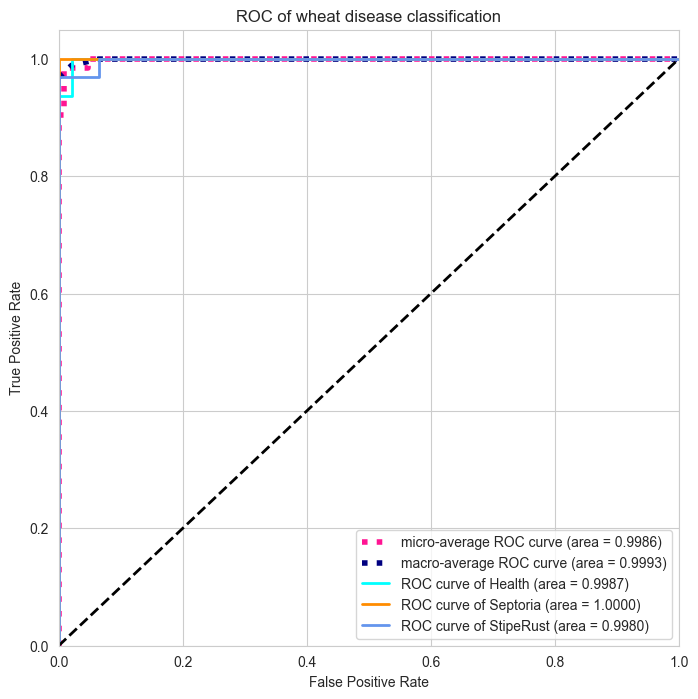

In [34]:
from itertools import cycle

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_true.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"], tpr["macro"], _ = all_fpr, mean_tpr, np.zeros_like(all_fpr)
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(8, 8))

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
class_names = ["Health", "Septoria", "StipeRust"] 

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of {0} (area = {1:0.4f})'
                   ''.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of wheat disease classification')
plt.legend(loc="lower right")
plt.show()

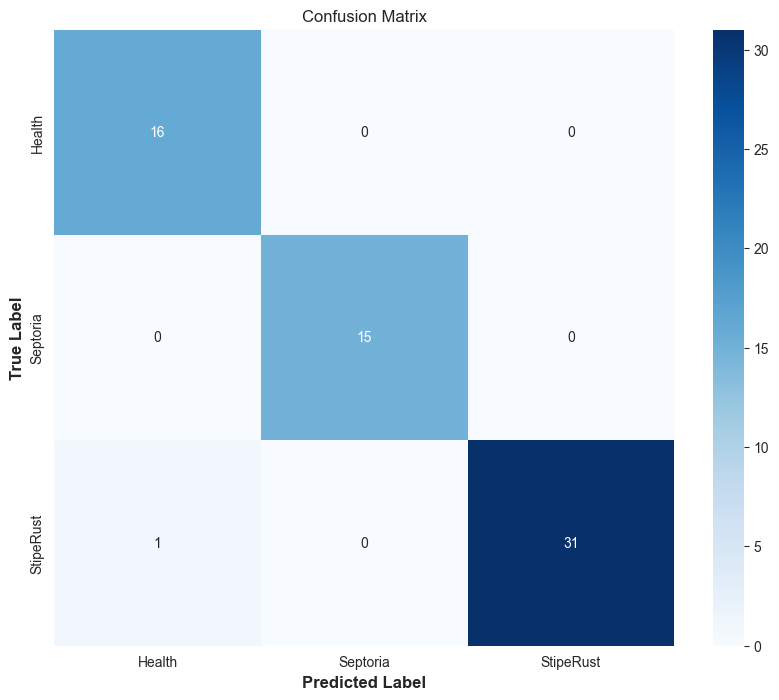

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_names = ["Health", "Septoria", "StipeRust"]  

y_pred = np.argmax(y_probs, axis=1)
y_true_classes = np.argmax(y_true, axis=1)  

cm = confusion_matrix(y_true_classes, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.show()

In [42]:
from sklearn.metrics import precision_score, recall_score, f1_score

recall = recall_score(y_true_classes, y_pred, average='weighted')
precision = precision_score(y_true_classes, y_pred, average='weighted')
f1 = f1_score(y_true_classes, y_pred, average='weighted')

recall = recall * 100
recall = "{:.2f}%".format(recall)
precision = precision * 100
precision = "{:.2f}%".format(precision)
f1 = f1 * 100
f1 = "{:.2f}%".format(f1)

print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")

Recall: 98.41%
Precision: 98.51%
F1 Score: 98.42%


In [43]:
import numpy as np
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true_classes, y_pred)
n_classes = cm.shape[0]

specificity = np.zeros(n_classes)
sensitivity = np.zeros(n_classes)
for i in range(n_classes):
    TN = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    FP = cm[:, i].sum() - cm[i, i]
    specificity[i] = TN / (TN + FP) if (TN + FP) != 0 else 0

    TP = cm[i, i]
    FN = cm[i, :].sum() - TP
    sensitivity[i] = TP / (TP + FN) if (TP + FN) != 0 else 0

weights = cm.sum(axis=1) / cm.sum()

weighted_specificity = np.average(specificity, weights=weights)
weighted_sensitivity = np.average(sensitivity, weights=weights)

weighted_specificity = weighted_specificity * 100
weighted_specificity = "{:.2f}%".format(weighted_specificity)
weighted_sensitivity = weighted_sensitivity * 100
weighted_sensitivity = "{:.2f}%".format(weighted_sensitivity)

print(f"Weighted Specificity: {weighted_specificity}")
print(f"Weighted Sensitivity: {weighted_sensitivity}")


Weighted Specificity: 99.46%
Weighted Sensitivity: 98.41%


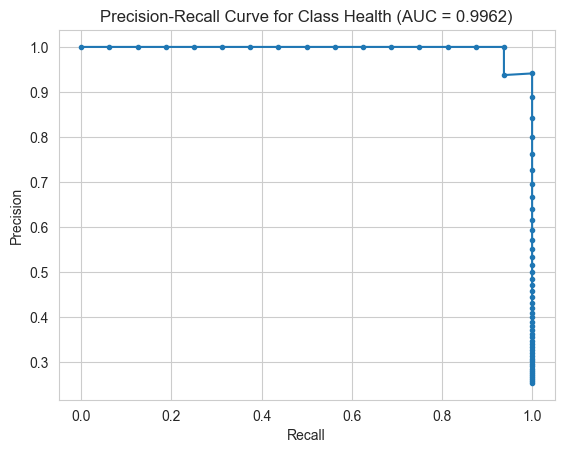

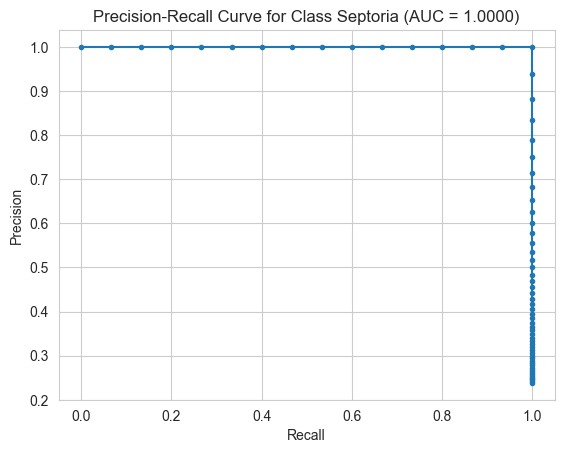

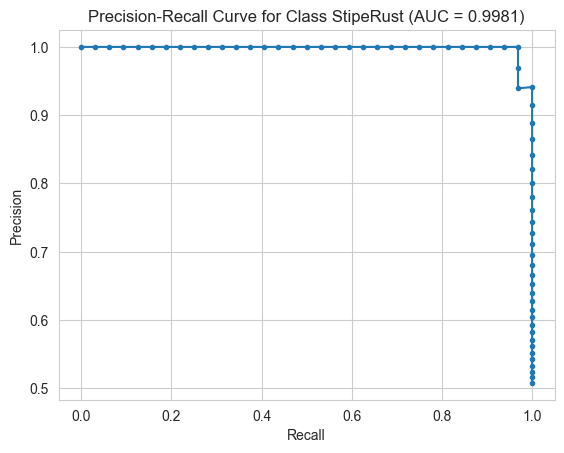

In [44]:
from sklearn.metrics import auc

for i in range(n_classes):
    precision, recall, thresholds = precision_recall_curve(y_true[:, i], y_probs[:, i])
    auc_score = auc(recall, precision)

    plt.figure()
    
    plt.plot(recall, precision, marker='.')
    
    class_names = ["Health", "Septoria", "StipeRust"]
    plt.title('Precision-Recall Curve for Class {} (AUC = {:.4f})'.format(class_names[i], auc_score))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()


In [45]:
def mcc_score(y_true, y_pred, class_label):
    """
    Calculate Matthew Correlation Coefficient for a specific class.
    """
    cm = confusion_matrix(y_true, y_pred)

    tp = cm[class_label, class_label]
    tn = np.sum(cm) - np.sum(cm[class_label, :]) - np.sum(cm[:, class_label]) + tp
    fp = np.sum(cm[:, class_label]) - tp
    fn = np.sum(cm[class_label, :]) - tp

    numerator = (tp * tn) - (fp * fn)
    denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    # To avoid division by zero
    if denominator == 0:
        return 0

    return numerator / denominator

y_true_classes = np.argmax(y_true, axis=1)
y_pred_classes = y_pred

mcc_scores = [mcc_score(y_true_classes, y_pred_classes, i) for i in range(n_classes)]

average_mcc = np.mean(mcc_scores)
average_mcc_percentage = average_mcc * 100
formatted_percentage = "{:.2f}%".format(average_mcc_percentage)
print(f"Average MCC: {formatted_percentage}")

Average MCC: 97.62%


In [ ]:
from keras import backend as K
import gc

K.clear_session()
gc.collect()
#
del combined_model